# RAPIDS & Scanpy Single-Cell RNA-seq Workflow on 1.3 Million Cells

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of 1M brain cells with Unified Virtual Memory to oversubscribe GPU memory. See the README for instructions to download this dataset.

## Change to the notebooks directory

Change into the *notebooks* directory. You may need to modify your path depending on where you cloned the repo.

In [1]:
import os 
os.chdir("/datasets/cnolet/workspace/rapids-single-cell-examples/notebooks")

## Import requirements

In [2]:
import numpy as np
import scanpy as sc
import anndata

import dask
import time

import cudf
import cuml
import cupy as cp

import os, wget

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans

from dask_cuda import initialize, LocalCUDACluster
from dask.distributed import Client, default_client

import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

We use the RAPIDS memory manager to enable Unified Virtual Memory management, which allows us to oversubscribe the GPU memory.

In [3]:
import rmm

def set_mem():
    rmm.reinitialize(managed_memory=True)
    cp.cuda.set_allocator(rmm.rmm_cupy_allocator)
    

cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES="0, 1, 2, 3, 4, 5, 6, 7")
client = Client(cluster)    

set_mem()
client.run(set_mem)

client

      Start worker at:      tcp://127.0.0.1:34195
INFO:distributed.worker:      Start worker at:      tcp://127.0.0.1:34195


Connection method: Cluster object,Cluster type: LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:34479,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:34195,Total threads: 1
Dashboard: http://127.0.0.1:39003/status,Memory: 125.97 GiB
Nanny: tcp://127.0.0.1:46085,


## Input data

In the cell below, we provide the path to the sparse `.h5ad` file containing the count matrix to analyze.

To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

In [4]:
input_file = "../data/1M_brain_cells_10X.sparse.h5ad"

if not os.path.exists(input_file):
    print('Downloading import file...')
    os.makedirs('../data', exist_ok=True)
    wget.download('https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/1M_brain_cells_10X.sparse.h5ad',
              input_file)

## Set parameters

In [5]:
# marker genes
MITO_GENE_PREFIX = "mt-" # Prefix for mitochondrial genes to regress out
markers = ["Stmn2", "Hes1", "Olig1"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
n_top_genes = 4000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# Batched PCA
pca_train_ratio = 0.35 # Fraction of cells to use for PCA training
n_pca_batches = 8

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

In [6]:
start = time.time()

## Load and Preprocess Data

In [7]:
data_load_preprocess_start = time.time()

Below, we load the sparse count matrix from the `.h5ad` file into GPU using a custom function. While reading the dataset, filters are applied on the count matrix to remove cells with an extreme number of genes expressed. Genes will zero expression in all cells are also eliminated. 

The custom function uses [Dask](https://dask.org) to partition data. The above mentioned filters are applied on individual partitions. Usage of Dask along with cupy provides the following benefits:
- Parallelized data loading when multiple GPUs are available
- Ability to partition the data allows pre-processing large datasets

Filters are applied on individual batches of cells. Elementwise or cell-level normalization operations are also performed while reading. For this example, the following two operations are performed:
- Normalize the count matrix so that the total counts in each cell sum to 1e4.
- Log transform the count matrix.

In [8]:
%%time
def partial_post_processor(partial_data):
    partial_data = rapids_scanpy_funcs.normalize_total(partial_data, target_sum=1e4)
    return partial_data.log1p()

dask_sparse_arr, genes, query = rapids_scanpy_funcs.read_with_filter(client,
                                                       input_file,
                                                       min_genes_per_cell=min_genes_per_cell,
                                                       max_genes_per_cell=max_genes_per_cell,
                                                       partial_post_processor=partial_post_processor)
dask_sparse_arr = dask_sparse_arr.persist()

CPU times: user 6.81 s, sys: 1.57 s, total: 8.38 s
Wall time: 41.1 s


Verify the shape of the resulting sparse matrix:

In [9]:
dask_sparse_arr.shape

(1306127, 24002)

### Select Most Variable Genes

Before filtering the count matrix, we save the 'raw' expression values of the marker genes to use for labeling cells afterward.

In [10]:
%%time
marker_genes_raw = {}
i = 0
for index in genes[genes.isin(markers)].index.to_arrow().to_pylist():
    marker_genes_raw[markers[i]] = dask_sparse_arr[:, index].compute().toarray().ravel()
    i += 1

CPU times: user 770 ms, sys: 350 ms, total: 1.12 s
Wall time: 7.51 s


Filter the count matrix to retain only the most variable genes.

In [11]:
%%time

hvg = rapids_scanpy_funcs.highly_variable_genes_filter(client, dask_sparse_arr, genes, n_top_genes=n_top_genes)

genes = genes[hvg]
dask_sparse_arr = dask_sparse_arr[:, hvg]
sparse_gpu_array = dask_sparse_arr.compute()

# del dask_sparse_arr
del hvg

CPU times: user 2.07 s, sys: 4.92 s, total: 6.99 s
Wall time: 8.83 s


### Regress out confounding factors (number of counts, mitochondrial gene expression)

We can now perform regression on the count matrix to correct for confounding factors -  for example purposes, we use the number of counts and the expression of mitochondrial genes (named starting with `mt-`).

We now calculate the total counts and the percentage of mitochondrial counts for each cell.

In [12]:
%%time
sparse_gpu_array = sparse_gpu_array.tocsc()

mito_genes = genes.str.startswith(MITO_GENE_PREFIX).values
n_counts = sparse_gpu_array.sum(axis=1)
percent_mito = (sparse_gpu_array[:,mito_genes].sum(axis=1) / n_counts).ravel()

n_counts = cp.array(n_counts).ravel()
percent_mito = cp.array(percent_mito).ravel()

CPU times: user 525 ms, sys: 259 ms, total: 784 ms
Wall time: 772 ms


In [13]:
del sparse_gpu_array

And perform regression:

In [14]:
%%time
n_rows = dask_sparse_arr.shape[0]
n_cols = dask_sparse_arr.shape[1]
dask_sparse_arr = dask_sparse_arr.map_blocks(lambda x: x.todense(), dtype="float32", meta=cp.array(cp.zeros((0,)))).T
dask_sparse_arr = dask_sparse_arr.rechunk((500, n_rows)).persist()
dask_sparse_arr.compute_chunk_sizes()

CPU times: user 1.37 s, sys: 327 ms, total: 1.7 s
Wall time: 17.7 s


dask.array<rechunk-merge, shape=(4000, 1291337), dtype=float32, chunksize=(500, 1291337), chunktype=cupy.ndarray>

In [15]:
%%time
import math
dask_sparse_arr = dask_sparse_arr.map_blocks(lambda x: rapids_scanpy_funcs.regress_out(x.T, n_counts, percent_mito).T, dtype="float32", meta=cp.array(cp.zeros(0,))).T
dask_sparse_arr = dask_sparse_arr.rechunk((math.ceil(n_rows/8), n_cols)).persist()
dask_sparse_arr.compute_chunk_sizes()

CPU times: user 2.17 s, sys: 930 ms, total: 3.1 s
Wall time: 35.1 s


dask.array<rechunk-merge, shape=(1291337, 4000), dtype=float32, chunksize=(163266, 4000), chunktype=cupy.ndarray>

### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.

In [16]:
%%time
mean = dask_sparse_arr.mean(axis=0)
dask_sparse_arr -= mean
stddev = cp.sqrt(dask_sparse_arr.var(axis=0).compute())
dask_sparse_arr /= stddev
dask_sparse_arr = dask.array.clip(dask_sparse_arr, 0, 10).persist()
del mean, stddev

CPU times: user 165 ms, sys: 56.5 ms, total: 222 ms
Wall time: 2.23 s


In [17]:
data_load_preprocess_time = time.time()
print("Total data load and preprocessing time: %s" % (data_load_preprocess_time-data_load_preprocess_start))

Total data load and preprocessing time: 113.3812141418457


## Cluster & Visualize

### Reduce

We use PCA to reduce the dimensionality of the matrix to its top 50 principal components.

If the number of cells was smaller, we would use the command `adata.obsm["X_pca"] = cuml.dask.decomposition.PCA(n_components=n_components, output_type="numpy").fit_transform(dask_sparse_arr)` to perform PCA on all the cells.

However, we cannot perform PCA on the complete dataset using a single GPU. Therefore, we use the batched PCA function in `utils.py`, which uses only a fraction of the total cells to train PCA.

In [18]:
%%time
pca = PCA(n_components=50).fit(dask_sparse_arr[:int(0.35*dask_sparse_arr.shape[0])].compute())

pca_data = dask_sparse_arr.map_blocks(lambda x: pca.transform(x), dtype="float32", meta=cp.zeros((0,))).persist()
pca_data.compute_chunk_sizes()

CPU times: user 20.3 s, sys: 21.3 s, total: 41.6 s
Wall time: 44.2 s


dask.array<lambda, shape=(1291337, 50), dtype=float32, chunksize=(163266, 50), chunktype=cupy.ndarray>

We store the preprocessed count matrix as an AnnData object, which is currently in host memory. We also add the expression levels of the marker genes as observations to the annData object.

In [19]:
%%time
local_pca = pca_data.compute()
adata = anndata.AnnData(local_pca.get())

CPU times: user 1.15 s, sys: 651 ms, total: 1.8 s
Wall time: 1.78 s


In [20]:
pca_data.shape

(1291337, 50)

### t-SNE + K-means

We cluster the cells using k-means on the principal components. For example purposes, we set k=35.

In [21]:
%%time
adata.obsm['X_tsne'] = TSNE().fit_transform(adata.X[:,:tsne_n_pcs])

[W] [11:47:38.872098] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 36.4 s, sys: 19.6 s, total: 56 s
Wall time: 55.5 s


In [22]:
%%time
kmeans = KMeans(n_clusters=k, init="k-means++", random_state=0).fit(adata.X)
adata.obs['kmeans'] = kmeans.labels_.astype(str)

CPU times: user 1.32 s, sys: 349 ms, total: 1.67 s
Wall time: 1.63 s


We visualize the cells using t-SNE and label cells by color according to the k-means clustering.

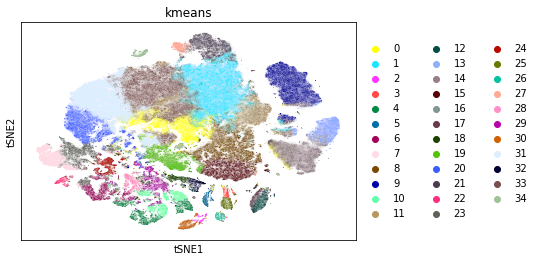

CPU times: user 6.98 s, sys: 618 ms, total: 7.6 s
Wall time: 7.05 s


In [23]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

### UMAP + Graph clustering

We can also visualize the cells using the UMAP algorithm in Rapids. Before UMAP, we need to construct a k-nearest neighbors graph in which each cell is connected to its nearest neighbors. This can be done conveniently using rapids functionality already integrated into Scanpy.

Note that Scanpy uses an approximation to the nearest neighbors on the CPU while the GPU version performs an exact search. While both methods are known to yield useful results, some differences in the resulting visualization and clusters can be observed.

In [24]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')

CPU times: user 1min, sys: 13 s, total: 1min 13s
Wall time: 1min 11s


The UMAP function from Rapids is also integrated into Scanpy.

In [25]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

CPU times: user 24 s, sys: 11.8 s, total: 35.8 s
Wall time: 35.5 s


Next, we use the Louvain algorithm for graph-based clustering.

In [26]:
%%time
sc.tl.louvain(adata, flavor='rapids')

CPU times: user 2.27 s, sys: 687 ms, total: 2.95 s
Wall time: 2.88 s


We plot the cells using the UMAP visualization, and using the Louvain clusters as labels.

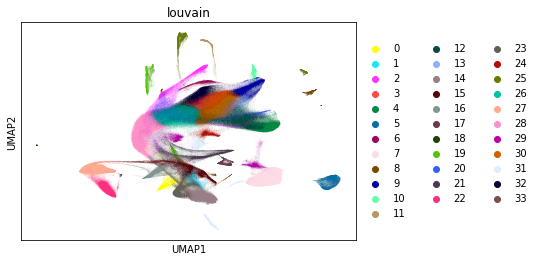

CPU times: user 7.39 s, sys: 942 ms, total: 8.34 s
Wall time: 7.16 s


In [27]:
%%time
sc.pl.umap(adata, color=["louvain"])

We can also use the Leiden clustering method in RAPIDS. This method has not been integrated into Scanpy and needs to be called separately.

In [28]:
%%time
adata.obs['leiden'] = rapids_scanpy_funcs.leiden(adata)

CPU times: user 1.61 s, sys: 622 ms, total: 2.23 s
Wall time: 2.19 s


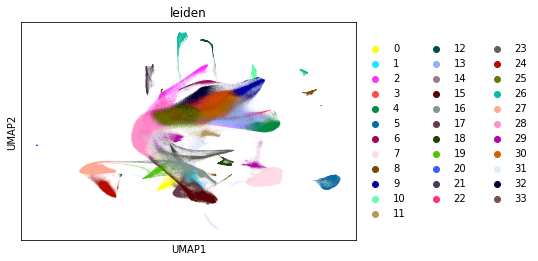

CPU times: user 6.95 s, sys: 523 ms, total: 7.48 s
Wall time: 6.85 s


In [29]:
%%time
sc.pl.umap(adata, color=["leiden"])

In [30]:
print("Full time: %s" % (time.time() - start))

client.shutdown()
cluster.close()

Full time: 349.65317606925964


TypeError: Level not an integer or a valid string: None

Failed to reconnect to scheduler after 30.00 seconds, closing client
